In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
df_data = pd.read_csv('./data/encirclement/FV_LPV_circle.csv')

In [60]:
df_data.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000
mean,57.677641,12073.156757,28.348870,32.172139,23.196058,1.226536,120.023080
std,34.134563,2753.326448,10.934123,6.797948,7.762541,0.638246,22.607108
min,0.000000,7928.000000,10.662000,20.553300,10.070100,0.000000,0.000000
25%,28.000000,9287.500000,17.399000,25.450300,15.544900,1.000000,112.167000
50%,57.000000,11885.000000,28.700500,32.461600,23.129700,1.000000,122.833000
75%,87.000000,14401.000000,39.200200,39.203600,30.727050,1.000000,133.143000
max,117.000000,16517.000000,46.666900,41.712200,34.601800,3.000000,161.714000


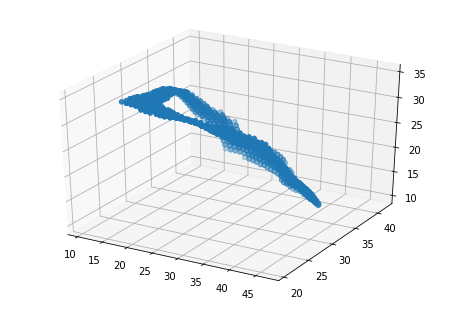

In [61]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_data['X'], df_data['Y'], df_data['Z'])
plt.show()

In [ ]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

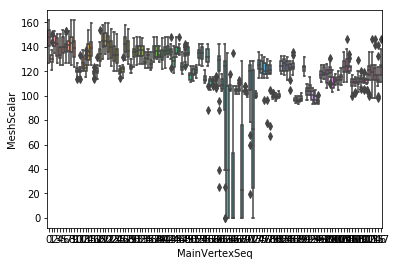

In [64]:
ax = sns.boxplot(x="MainVertexSeq", y="MeshScalar", data=df_data_scalars)

In [67]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

In [68]:
g1.head(2)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
0,0,8193.0,31.1068,39.8702,11.5681,1.0,148.167
1,1,8452.0,37.0817,37.0955,12.2195,1.0,129.800


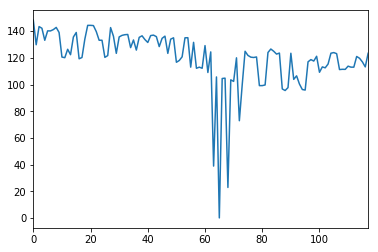

In [70]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [9]:
center_data = [df_data['X'].mean(), df_data['Y'].mean(), df_data['Z'].mean()]

In [9]:
center_data

[28.348869926289929, 32.172139213759216, 23.196058427518427]

In [4]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

In [5]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

In [ ]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [6]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [7]:
def point_theta(center, A):
    thetas = []; 
    Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    for index, row in A.iterrows():
        pt = [row['X'], row['Y'], row['Z']]
        theta = angle_between(Ref_pt, pt)
        thetas.append(theta)
    return thetas


In [10]:
thetas = point_theta(center_data, df_data)

In [11]:
thetas_df = pd.Series(thetas, name='theta');

In [12]:
df_data_with_theta = pd.concat([df_data, thetas_df], axis=1)

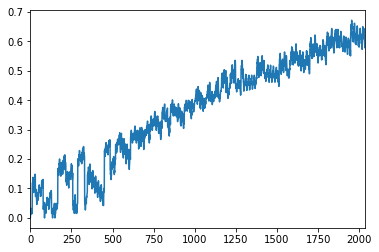

In [15]:
sns.tsplot(df_data_with_theta['theta'])

In [16]:
df_data_with_thetas_sorted = df_data_with_theta.sort_values(by='theta')

In [17]:
df_data_with_thetas_sorted.head(10)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,8193,31.2629,39.8702,11.5736,0,154.000,0.000000
1,0,8193,31.2629,39.8702,11.5736,3,154.000,0.000000
87,5,8193,31.2629,39.8702,11.5736,1,154.000,0.000000
150,9,8193,31.2629,39.8702,11.5736,2,154.000,0.000000
136,8,8193,31.2629,39.8702,11.5736,1,154.000,0.000000
153,9,8194,31.8162,39.7653,11.1467,1,143.800,0.013216
88,5,8194,31.8162,39.7653,11.1467,1,143.800,0.013216
140,8,8194,31.8162,39.7653,11.1467,1,143.800,0.013216
9,0,8194,31.8162,39.7653,11.1467,2,143.800,0.013216
151,9,8192,30.4649,40.1000,11.5681,1,159.429,0.014949


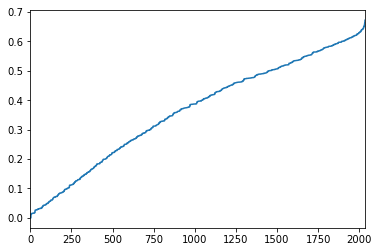

In [18]:
sns.tsplot(df_data_with_thetas_sorted['theta'])

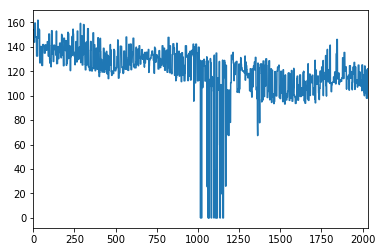

In [19]:
sns.tsplot(df_data_with_thetas_sorted['MeshScalar'])

In [20]:
df_data_with_thetas_sorted.head(15)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,8193,31.2629,39.8702,11.5736,0,154.000,0.000000
1,0,8193,31.2629,39.8702,11.5736,3,154.000,0.000000
87,5,8193,31.2629,39.8702,11.5736,1,154.000,0.000000
150,9,8193,31.2629,39.8702,11.5736,2,154.000,0.000000
136,8,8193,31.2629,39.8702,11.5736,1,154.000,0.000000
153,9,8194,31.8162,39.7653,11.1467,1,143.800,0.013216
88,5,8194,31.8162,39.7653,11.1467,1,143.800,0.013216
140,8,8194,31.8162,39.7653,11.1467,1,143.800,0.013216
9,0,8194,31.8162,39.7653,11.1467,2,143.800,0.013216
151,9,8192,30.4649,40.1000,11.5681,1,159.429,0.014949


In [21]:
df_data_with_thetas_sorted_nodupes = df_data_with_thetas_sorted.drop_duplicates(subset='VertexID', keep='last');

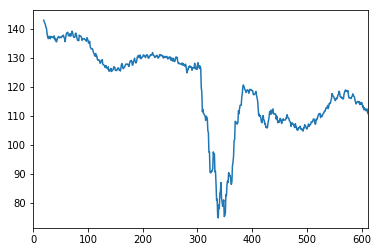

In [26]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted_nodupes['MeshScalar'],20))

In [23]:
df_data_with_thetas_sorted_nodupes.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
count,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000
mean,57.057096,12029.523654,28.529352,32.181743,23.058631,1.137031,119.537921,0.363743
std,34.338068,2784.914748,10.922083,6.817273,7.868748,0.505669,22.865332,0.177723
min,0.000000,7928.000000,10.662000,20.553300,10.070100,0.000000,0.000000,0.000000
25%,27.000000,9263.000000,17.670700,25.330600,15.281500,1.000000,112.143000,0.214769
50%,57.000000,11798.000000,28.897200,32.793800,23.073600,1.000000,122.833000,0.394079
75%,87.000000,14402.000000,39.203200,39.053300,30.722700,1.000000,132.400000,0.511803
max,117.000000,16517.000000,46.666900,41.712200,34.601800,3.000000,161.714000,0.671654
